In [1]:
import sys
sys.path.append('./../prepping/')

import numpy as np
import pandas as pd

from scipy import linalg
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.spatial import distance

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import silhouette_score
from sklearn.metrics import normalized_mutual_info_score

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
y = np.squeeze(pd.read_csv('./../../../data_source/to_analysis/target_dfs.csv', index_col=0).values)
X = pd.read_csv('./../../../data_source/to_analysis/anomaly_filtered_concat.csv',index_col=0)
X.head()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxis,original_shape_MajorAxis,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MinorAxis,original_shape_Sphericity,...,PET_original_ngtdm_Complexity_128bins,PET_original_ngtdm_Contrast_32bins,PET_original_ngtdm_Contrast_64bins,PET_original_ngtdm_Contrast_128bins,PET_original_ngtdm_Strength_32bins,PET_original_ngtdm_Strength_64bins,PET_original_ngtdm_Strength_128bins,PETparam_SUVpeak,PETparam_MTV,PETparam_TLG
patient,,,,,,,,,,,,,,,,,,,,,
2,0.738882,0.723925,27.060529,37.380273,41.976184,44.598206,42.720019,45.617979,27.619612,0.661532,...,35043.624331,0.087280,0.162078,0.321302,4.795040,20.583636,82.226867,21.616549,7.384,124.870726
4,0.796900,0.629917,19.845151,31.504408,38.587563,35.468296,29.410882,38.704005,25.105855,0.701721,...,14564.029341,0.063470,0.112029,0.211571,4.960538,21.947247,92.427131,15.296275,3.406,41.554406
5,0.601166,0.535182,22.513266,42.066543,46.065171,43.011626,32.015621,46.454279,25.288987,0.758659,...,10319.058348,0.050778,0.090780,0.173466,1.955137,8.605178,35.576274,14.473272,7.934,86.228420
8,0.784593,0.414263,30.264199,73.055482,74.148500,80.956779,65.764732,83.438600,57.318801,0.519989,...,5608.554961,0.023681,0.037293,0.064838,0.407563,2.031182,9.261979,10.510859,26.926,205.413389
10,0.690320,0.539743,19.449801,36.035312,33.286634,38.013156,33.015148,43.150898,24.875896,0.643822,...,1622.329095,0.028316,0.043614,0.075239,0.453153,2.224724,10.141370,7.213190,6.041,32.103770


In [11]:
data = pd.concat((X, dfs), axis=1)
data.shape

(198, 551)

In [12]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

/Users/severinlangberg/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/severinlangberg/anaconda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Feature Scatter Plot

In [13]:
X_shape = X.filter(regex='shape')
X_PET = X.filter(regex='PET')
X_CT = X.filter(regex='CT')

clinical_cols = np.logical_not(
    np.isin(X.columns, np.concatenate((X_shape.columns, X_PET.columns, X_CT.columns)))
)
X_clinical = X.iloc[:, clinical_cols]

In [14]:
scaler = StandardScaler()

X_shape_std = scaler.fit_transform(X_shape)
X_PET_std = scaler.fit_transform(X_PET)
X_CT_std = scaler.fit_transform(X_CT)

X_clinical_std = scaler.fit_transform(X_clinical)

/Users/severinlangberg/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/severinlangberg/anaconda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Text(0.5, 0, 'Patient Indicator')

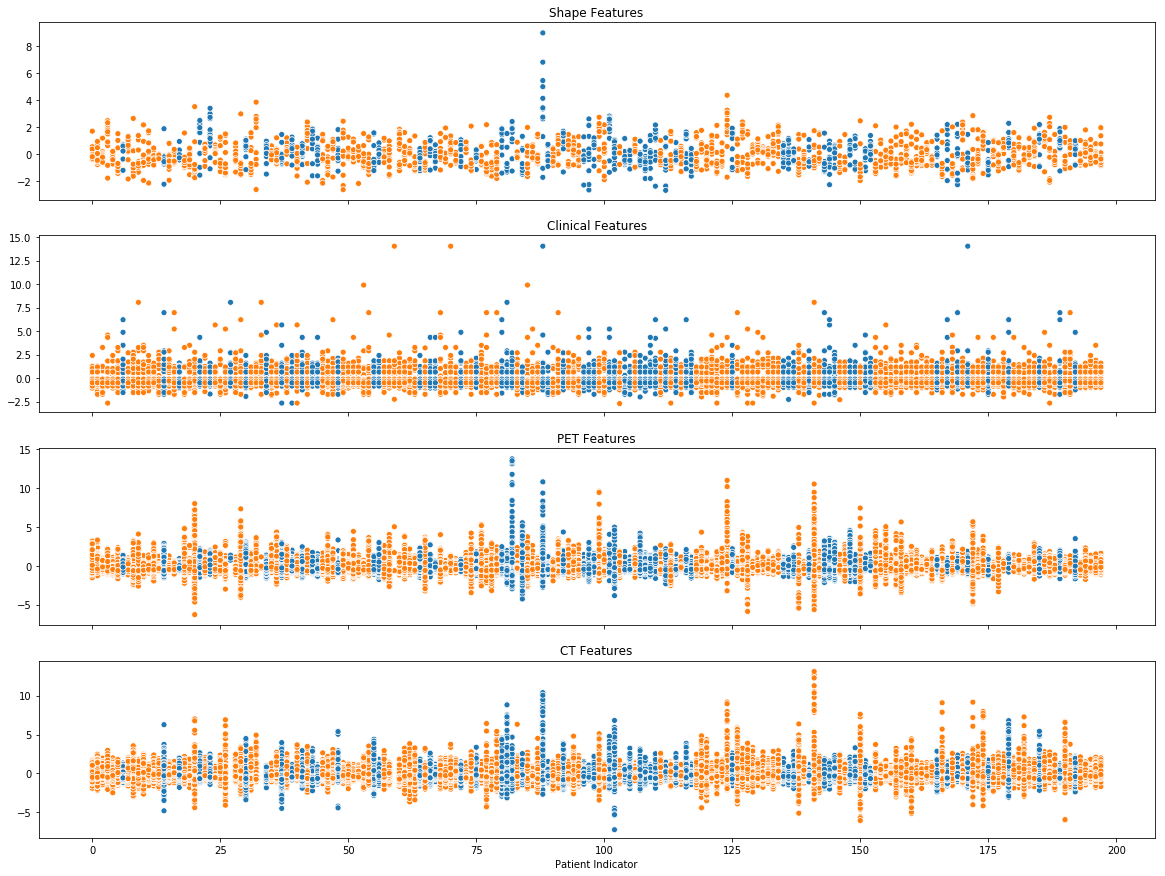

In [18]:
x_coords = np.arange(198)

fig, axis = plt.subplots(
    nrows=4, 
    sharex=True,
    figsize=(20, 15)
)#gridspec_kw={'width_ratios': [3, 1]})
axis[0].set_title('Shape Features')
for shape_col in X_shape_std.T:
    sns.scatterplot(
        x=x_coords,
        y=shape_col,
        hue=y==0,
        legend=False,
        ax=axis[0]
    )
axis[1].set_title('Clinical Features')
for clinical_col in X_clinical_std.T:
    sns.scatterplot(
        x=x_coords,
        y=clinical_col,
        hue=y==0,
        legend=False,
        ax=axis[1]
    )
axis[2].set_title('PET Features')
for PET_col in X_PET_std.T:
    sns.scatterplot(
        x=x_coords,
        y=PET_col,
        hue=y==0,
        legend=False,
        ax=axis[2]
    )
axis[3].set_title('CT Features')
for CT_col in X_CT_std.T:
    sns.scatterplot(
        x=x_coords,
        y=CT_col,
        hue=y==0,
        legend=False,
        ax=axis[3]
    )
plt.xlabel('Patient Indicator')

## Feature Violin Plot

/Users/severinlangberg/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


KeyboardInterrupt: 

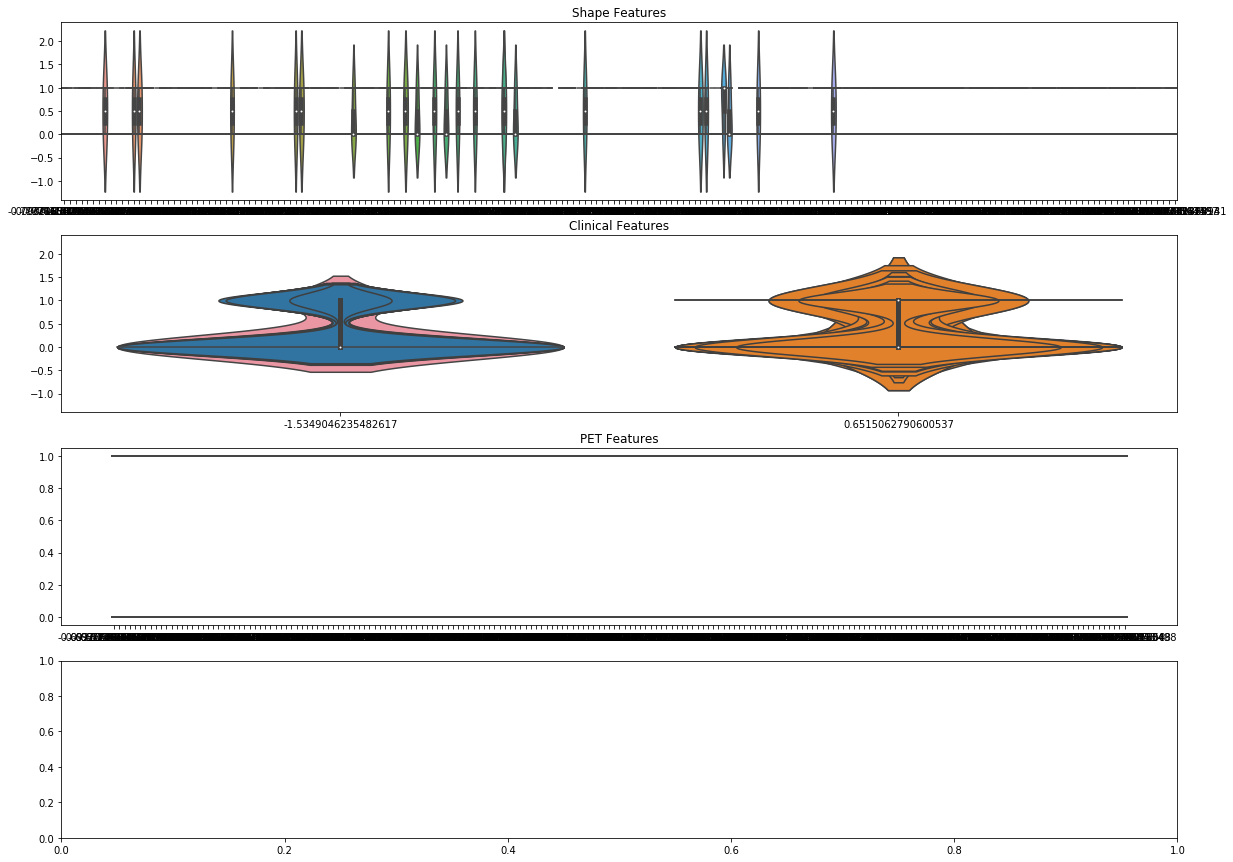

In [17]:
y_dfs = np.squeeze(dfs.values)


fig, axis = plt.subplots(nrows=4, figsize=(20, 15))#gridspec_kw={'width_ratios': [3, 1]})
axis[0].set_title('Shape Features')
for shape_col in X_shape_std.T:
    sns.violinplot(
        x=shape_col,
        y=y_dfs,
        legend=False,
        ax=axis[0]
    )
axis[1].set_title('Clinical Features')
for clinical_col in X_clinical_std.T:
    sns.violinplot(
        x=clinical_col,
        y=y_dfs,
        legend=False,
        ax=axis[1]
    )
axis[2].set_title('PET Features')
for PET_col in X_PET_std.T:
    sns.violinplot(
        x=PET_col,
        y=y_dfs,
        legend=False,
        ax=axis[2]
    )
axis[3].set_title('CT Features')
for CT_col in X_CT_std.T:
    sns.violinplot(
        x=CT_col,
        y=y_dfs,
        legend=False,
        ax=axis[3]
    )

## Link HPV and Patient Sex

In [11]:
clinical = pd.read_excel('./../../../data_source/tabular/clinical_params.xlsx', index_col=0)
clinical.head()

,Alder,Kjønn,ICD10 kort,T-klassifisering,N-klassifisering,Stadium,Histologi,HPV-status,ECOG,Charlson,Pakkeår,Naxogin dager,Cisplatin
Pasient-ID,,,,,,,,,,,,,
1,57.854795,M,C01,4,2,4a,1.0,2,1,0,32.141096,29.0,0
2,60.832877,M,C09,2,2,4a,0.0,2,0,0,0.000000,39.0,6
3,75.663014,M,C32,2,0,2,1.0,2,0,0,55.663014,41.0,0
4,49.906849,K,C09,2,2,4a,0.0,2,0,0,4.786027,33.0,5
5,54.238356,K,C09,2,0,2,0.0,0,0,0,0.000000,42.0,0


/Users/severinlangberg/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


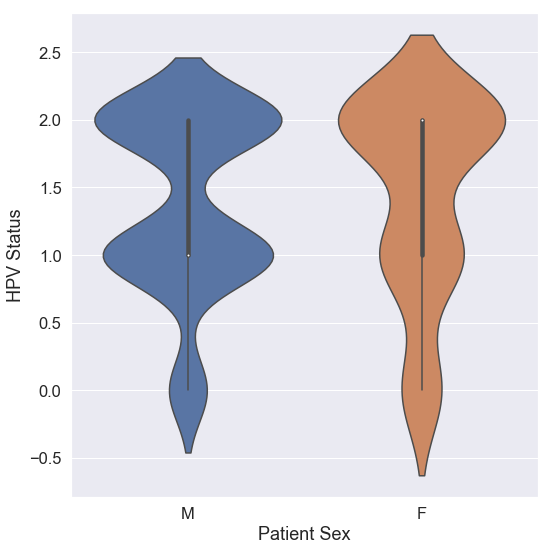

In [20]:
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.5)
sns.violinplot(x='Kjønn', y='HPV-status', data=clinical)
plt.xticks([0, 1], ['M', 'F'])
plt.xlabel('Patient Sex')
plt.ylabel('HPV Status')
plt.tight_layout()
plt.savefig(
    './../../../figures/sex_vs_hpv.png',
    bbox_inches='tight',
    transparent=True,
    dpi=600, 
)

## Feature Normality Tests

Parametric statistical methods assume that the data has a known and specific distribution, often a Gaussian distribution. If a data sample is not Gaussian, then the assumptions of parametric statistical tests are violated and nonparametric statistical methods must be used. See [article](https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/). 

In the SciPy implementation of these tests, you can interpret the p value as follows.
* p <= alpha: reject H0, not normal.
* p > alpha: fail to reject H0, normal.

In [5]:
nrows, ncols = np.shape(X_std)
alpha = 0.05

In [6]:
non_gaussians = 0
for col_num in range(ncols):
    stat, p = shapiro(X_std[:, col_num])
    if p < alpha:
        non_gaussians = non_gaussians + 1
print(non_gaussians, 'out of', ncols, 'are not Gaussian')

553 out of 610 are not Gaussian


In [7]:
non_gaussians = 0
for col_num in range(ncols):
    stat, p = normaltest(X_std[:, col_num])
    if p < alpha:
        non_gaussians = non_gaussians + 1
print(non_gaussians, 'out of', ncols, 'are not Gaussian')

538 out of 610 are not Gaussian


/Users/severinlangberg/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<Figure size 576x576 with 0 Axes>

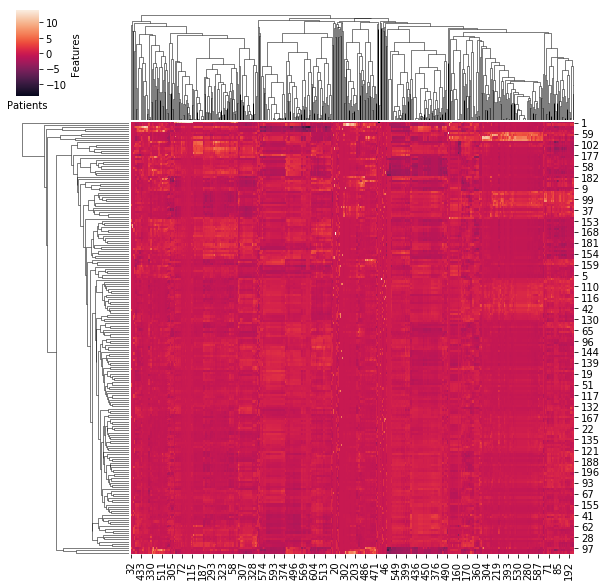

In [8]:
plt.figure(figsize=(8, 8))
sns.clustermap(X_std)
plt.xlabel('Patients')
plt.ylabel('Features')
plt.tight_layout()

# Bogowicz et al.

In [5]:
# Bogowicz:
# * Higher pretreatment tumor heterogeneity (CT quantified) associates worse prognosis in head and neck cancer and
#   HPV status.
# Read original clinical variables for HPV-status. Pearson correlation coefficient assumes that the variables for 
# which we have to calculate correlation coefficient should come out from a normal population. Now discrete 
# variables can never follow this assumption because normal distribution is a continuous distribution. On the other 
# hand, spearman correlation coefficient assumes no such thing. So calculate spearman correlation coefficient between 
# the variables.
# * Do correlation analysis (Spearman's and Kendall's coefficients) between tumor heteroginity and outcome.
# * Do correlation analysis (Spearman's and Kendall's coefficients) between tumor heteroginity and CT density.

In [10]:
shape_features = X.filter(regex='shape')
shape_features.head()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxis,original_shape_MajorAxis,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MinorAxis,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_Volume
patient,,,,,,,,,,,,,
2,0.738882,0.723925,27.060529,37.380273,41.976184,44.598206,42.720019,45.617979,27.619612,0.661532,4860.055715,0.283517,17142.0
4,0.796900,0.629917,19.845151,31.504408,38.587563,35.468296,29.410882,38.704005,25.105855,0.701721,3126.087371,0.323578,9661.0
5,0.600926,0.535140,22.515072,42.073251,46.065171,43.011626,32.015621,46.454279,25.282894,0.762365,4063.633046,0.250625,16214.0
8,0.784571,0.414247,30.263897,73.057649,74.148500,80.956779,65.764732,83.438600,57.318945,0.520001,15698.615155,0.226355,69354.0
10,0.690320,0.539743,19.449801,36.035312,33.286634,38.013156,33.015148,43.150898,24.875896,0.643822,3658.448414,0.340352,10749.0


In [16]:
shape_dfs = pd.concat((shape_features, dfs), axis=1)
shape_lrr = pd.concat((shape_features, lrr), axis=1)
shape_dfs.shape, shape_lrr.shape, shape_features.shape

((198, 14), (198, 14), (198, 13))

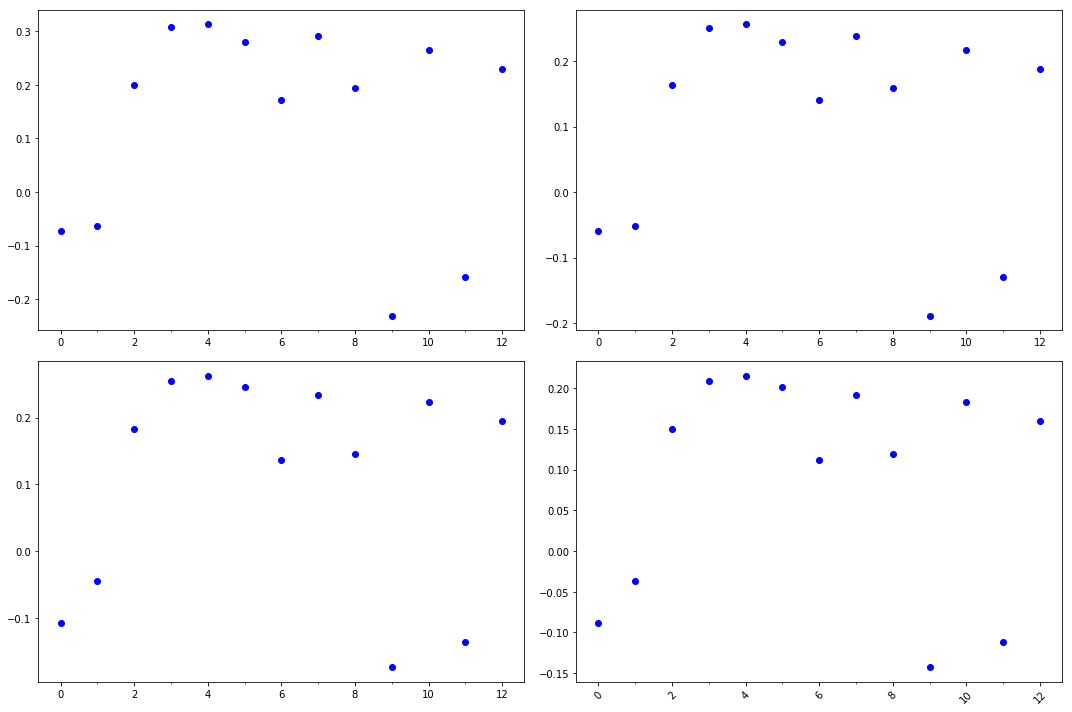

In [67]:
shape_dfs_spearman = shape_dfs.corr(method='spearman').dfs.values[:-1]
shape_dfs_kendall = shape_dfs.corr(method='kendall').dfs.values[:-1]

shape_lrr_spearman = shape_lrr.corr(method='spearman').lrr.values[:-1]
shape_lrr_kendall = shape_lrr.corr(method='kendall').lrr.values[:-1]

shape_labels = [label.split('_')[-1] for label in shape_dfs.columns[:-1]]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes[0, 0].plot(shape_dfs_spearman, 'bo')
axes[0, 1].plot(shape_dfs_kendall, 'bo')
axes[1, 0].plot(shape_lrr_spearman, 'bo')
axes[1, 1].plot(shape_lrr_kendall, 'bo')
for axis in axes.ravel():
    axis.set_xticks(np.arange(12), shape_labels)
    plt.xticks(rotation=45)
plt.tight_layout()

/Users/severinlangberg/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x1080 with 0 Axes>

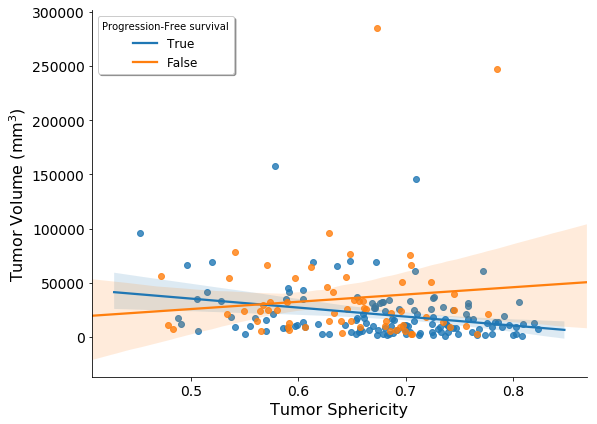

In [5]:
fig = plt.figure(figsize=(6, 15))
sns.lmplot(
    y='original_shape_Volume', 
    x='original_shape_Sphericity', 
    data=data,
    hue='dfs',
    height=6,
    aspect=1.4,
    legend=False
)
plt.ylabel(r'Tumor Volume (mm$^3$)', fontsize=16)
plt.xlabel(r'Tumor Sphericity', fontsize=16)
plt.legend(
    ['True', 'False'],
    title='Progression-Free survival', 
    fontsize=12,
    loc='best',
    shadow=True,
    fancybox=True
)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
plt.savefig(
    './../../../figures/tumor_volume_vs_shpericity.png',
    dpi=600,
    bbox_inches='tight',
    transparent=True,
)

# Patient sex distribution.

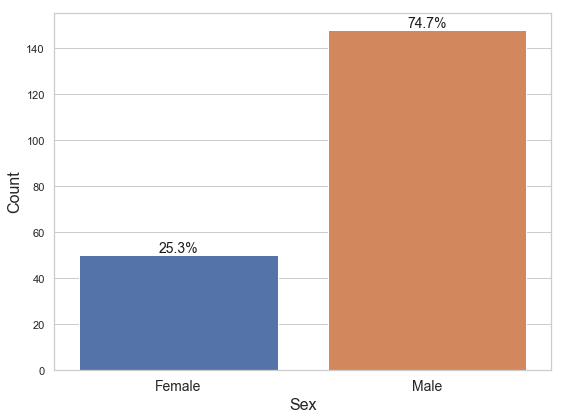

In [6]:
sns.set(style='whitegrid')
fig = plt.figure(figsize=(8, 6))
axis = sns.countplot(x='Sex_M', data=data, saturation=0.85)

plt.ylabel('Count', fontsize=16)
plt.xlabel('Sex', fontsize=16)
plt.xticks(range(2), ['Female', 'Male'], fontsize=14)

sex_ratios = [
    sum(data['Sex_M'] == 0) / data['Sex_M'].size, 
    sum(data['Sex_M'] == 1) / data['Sex_M'].size, 
]
for num, patch in enumerate(axis.patches):
    plt.annotate(
        '{:.1f}%'.format(sex_ratios[num] * 100),
        (patch.get_x() + patch.get_width() / 2.5, patch.get_height() + 1), 
        color='k', fontsize=14
    )
      
plt.tight_layout()
plt.savefig(
    './../../../figures/sex_distr.png', 
    bbox_inches='tight',
    transparent=True,
    dpi=600, 
)

# Outcome distribution

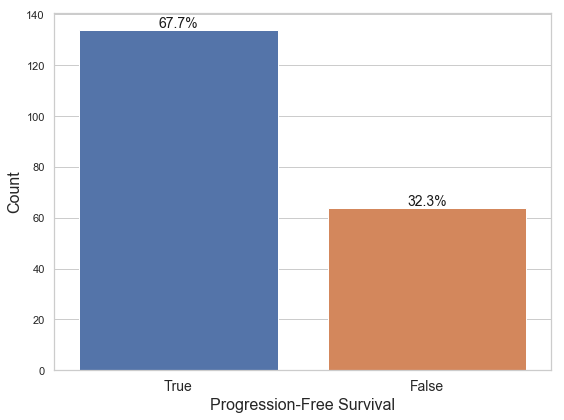

In [8]:
# DO TO: Divide each bar into sex distr.?
sns.set(style='whitegrid')
fig = plt.figure(figsize=(8, 6))
axis = sns.countplot(x='dfs', data=data, saturation=0.85)

plt.ylabel('Count', fontsize=16)
plt.xlabel('Progression-Free Survival', fontsize=16)
plt.xticks(range(2), ['True', 'False'], fontsize=14)

dfs_ratios = [
    sum(data['dfs'] == 0) / data['dfs'].size, 
    sum(data['dfs'] == 1) / data['dfs'].size, 
]
for num, patch in enumerate(axis.patches):
    plt.annotate(
        '{:.1f}%'.format(dfs_ratios[num] * 100),
        (patch.get_x() + patch.get_width() / 2.5, patch.get_height() + 1), 
        color='k', fontsize=14
    )
      
plt.tight_layout()
plt.savefig(
    './../../../figures/outcome_distr.png', 
    bbox_inches='tight',
    transparent=True,
    dpi=600, 
)

In [105]:
# Outcome vs smoking habits? What are most common causes for head and neck cancer?

## t-Distributed Stochastic Neighbor Embedding

In [111]:
from transforms import Whitening

# NOTE: Use PCA-cor when maximal compression is desirable.
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

pca_cor = Whitening(method='pca-cor')
Z_pca_cor = pca_cor.fit_transform(X_std )

/Users/severinlangberg/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/severinlangberg/anaconda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [ ]:
param_grid = 

# Recommended by scikit-learn + paper.
perplexity = np.arange(5, 50, 11)
# Recommended by scikit-learn + paper(?).
learning_rate = np.arange(10.0, 1000.0, 100)
early_exaggeration = np.arange(5, 50, 8)
n_iter = 2000

1.7125378847122192
1.9055677652359009
1.6321444511413574
1.3562469482421875
0.9187713265419006
0.6953402161598206


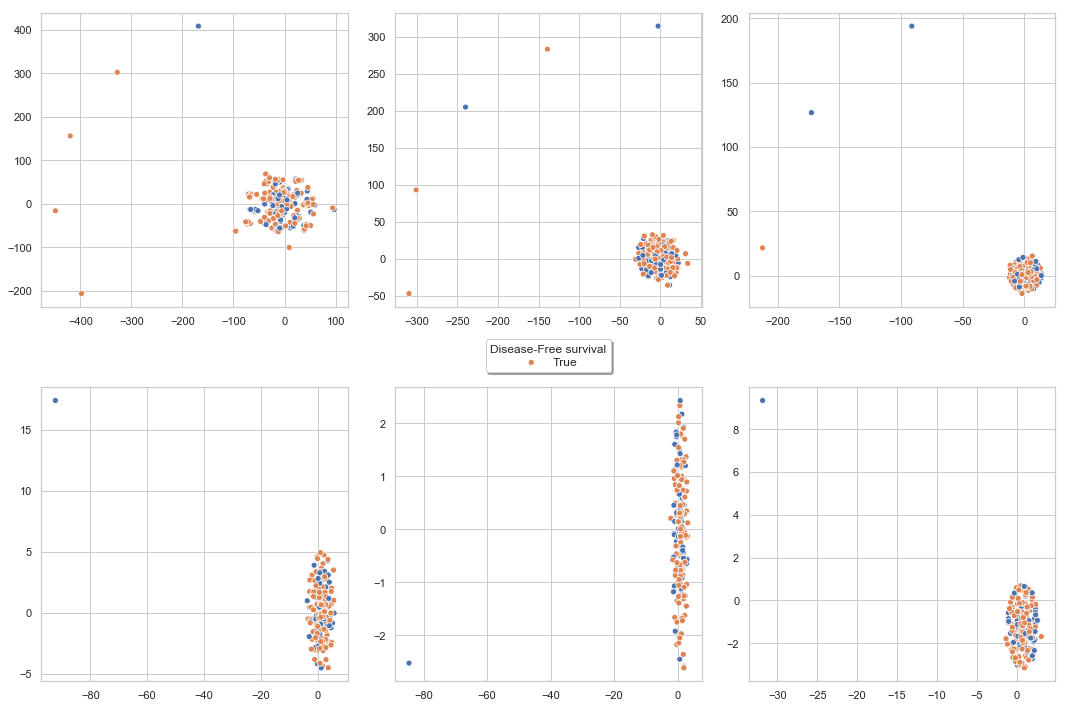

In [126]:
# https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html#sphx-glr-auto-examples-manifold-plot-t-sne-perplexity-py

# TODOS:
# * Possible to run SMAC optimization wrt. KL-divergence of t-SNE algorithm for parameter tuning?
# * Kullback-Leibler: Measuring the dissimilarity of distributions. t-SNE tries to maximize the similarity 
#   between two paramerterized probability distributions in the original high-dimensional space and 
#   the low-dimensional target (embedding) space. The similarity between the distributions is defined 
#   using the Kullback-Leibler divergence measure.

# THEORY:
# * http://jotterbach.github.io/2016/05/23/TSNE/

# NOTE:
# * Make sure the same scale is used over all features. Because manifold learning methods are based on a 
#   nearest-neighbor search, the algorithm may perform poorly otherwise. See StandardScaler for convenient 
#   ways of scaling heterogeneous data.
# * Note that noisy data can “short-circuit” the manifold, in essence acting as a bridge between parts of the 
#   manifold that would otherwise be well-separated.
# * Highly recommended to use another dimensionality reduction method to reduce the number of dimensions to a 
#   reasonable amount if the number of features is very high. 
# * Perplexity: how to balance attention between local and global aspects of your data
#   (a guess about the number of close neighbors each point has).
# * Perplexity values in the range (5 - 50) suggested by van der Maaten & Hinton. With perplexity 2, 
#   local variations dominate.
# * For the algorithm to operate properly, the perplexity really should be smaller than the number 
#   of points.
# * The most important thing is to iterate until reaching a stable configuration (selecting suffieciently 
#   large number of iters). Different data sets can require different numbers of iterations to converge.
# * You cannot see relative sizes of clusters in a t-SNE plot. 
# * Distances between well-separated clusters in a t-SNE plot may mean nothing.


# t-SNE hparam space: use log for testing a wider range of preplexity and learning rate values.
# Let num iter be large > 5000 and num comps = 2 (for visualzation).

# A Kullback–Leibler divergence of zero indicates that the two distributions in question are identical. 


# TODO: Grid search optimizing the KL-divergence. Plot the results.
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

y = np.squeeze(dfs.values)

perplexities = [2, 6, 15]
for num, perplexity in enumerate(perplexities):
    embedder = TSNE(
        n_components=2, 
        random_state=0, 
        learning_rate=80,
        perplexity=perplexity,
        n_iter=5000,
    )
    Z_embedded = embedder.fit_transform(Z_pca_cor)
    print(embedder.kl_divergence_)
    sns.scatterplot(
        Z_embedded[:, 0], 
        Z_embedded[:, 1], 
        hue=y==0,
        ax=axes[0, num],
        legend=False,
    )
axes[0, 1].legend(
    ['True', 'False'], 
    title='Disease-Free survival', 
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.09), 
    fancybox=True, 
    shadow=True, 
    fontsize=12,
    ncol=5,
    labelspacing=0.25
)
perplexities = [25, 45, 60]
for num, perplexity in enumerate(perplexities):
    embedder = TSNE(
        n_components=2, 
        random_state=0, 
        learning_rate=80,
        perplexity=perplexity,
        n_iter=5000,
    )
    Z_embedded = embedder.fit_transform(Z_pca_cor)
    print(embedder.kl_divergence_)
    sns.scatterplot(
        Z_embedded[:, 0], 
        Z_embedded[:, 1], 
        hue=y==0,
        ax=axes[1, num],
        legend=False
    )
#plt.savefig(
#    './../../../figures/image_sample_stats.png',
#    bbox_inches='tight',
#    transparent=True,
#    dpi=600, 
#)
plt.tight_layout()

# Dummy Classifier

In [ ]:
from sklearn.dummy import DummyClassifier

In [ ]:
# https://scikit-learn.org/stable/modules/model_evaluation.html#dummy-estimators
# https://medium.com/@mamonu/what-is-the-scikit-learn-dummy-classifier-95549d9cd44

# Correlations

In [ ]:
# TODO: 
# Look into stackoverflow question on relating continous features to a dichotomous target variable through manipulation 
# of correlation formulas.

# DGUFS

In [ ]:
from sklearn.metrics import normalized_mutual_info_score

# Import ConfigSpace and different types of parameters.
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter
from ConfigSpace.hyperparameters import UniformFloatHyperparameter
from ConfigSpace.hyperparameters import UniformIntegerHyperparameter

# Import SMAC-utilities
from smac.tae.execute_func import ExecuteTAFuncDict
from smac.scenario.scenario import Scenario
from smac.facade.smac_facade import SMAC

In [48]:
def similarity_matrix(X):
    """"""

    S = distance.squareform(distance.pdist(X))
    return -S / np.max(S)


def centering_matrix(nrows):
    """"""

    scaled = (np.ones((1, nrows)) / nrows)
    H = np.eye(nrows) - np.ones((nrows, 1)) * scaled
    # Experimental version where H := H / (n - 1).
    return H / (nrows - 1)

def solve_l20(Q, nfeats):

    # b(i) is the (l2-norm)^2 of the i-th row of Q.
    b = np.sum(Q ** 2, axis=1)[:, np.newaxis]
    idx = np.argsort(b[:, 0])[::-1]

    P = np.zeros(np.shape(Q), dtype=float)
    P[idx[:nfeats], :] = Q[idx[:nfeats], :]

    return P

def speed_up(C):
    """Refer to Simultaneous Clustering and Model Selection (SCAMS),
    CVPR2014.

    """
    diagmask = np.eye(np.shape(C)[0], dtype=bool)
    # Main diagonal = 0.
    C[diagmask] = 0

    # If C is (N x N), then tmp is (N*N x 1).
    tmp = np.reshape(C, (np.size(C), 1))
    # Remove the main diagonal elements of C in tmp. Then tmp has a
    # length of N * (N - 1).
    tmp = np.delete(tmp, np.where(diagmask.ravel()))
    # Scale to [0, 1] range.
    tmp = (tmp - np.min(tmp)) / (np.max(tmp) - np.min(tmp))

    affmaxo = C
    # affmaxo(~diagmask) is a column vector.
    affmaxo[np.logical_not(diagmask)] = tmp
    C_new = affmaxo

    return C_new


def solve_rank_lagrange(A, eta):
    """"""

    # Guarantee symmetry.
    A = 0.5 * (A + np.transpose(A))
    tempD, tempV = linalg.eig(A)
    # Discard the imaginary part.
    tempV = np.real(tempV)
    tmpD = np.real(tempD)

    tempD = np.real(np.diag(tempD))
    # eta * rank(P)
    tmpD[tmpD <= np.sqrt(eta)] = 0
    tempD = np.diag(tmpD)

    P = tempV.dot(tempD).dot(np.transpose(tempV))

    return P


def solve_l0_binary(Q, gamma):
    """"""

    P = np.copy(Q)
    # Each P_ij is in {0, 1}
    if gamma > 1:
        P[Q > 0.5 * (gamma + 1)] = 1
        P[Q <= 0.5 * (gamma + 1)] = 0
    else:
        P[Q > 1] = 1
        P[Q < np.sqrt(gamma)] = 0

    return P


def best_map(L1, L2):
    """Permute labels of L2 match L1 as good as possible.

    """

    if np.size(L1) != np.size(L2):
        raise RuntimeError('Got sizes L1: {} and L2 {}, when should be equal'
                           ''.format(np.size(L1), np.size(L2)))

    Label1 = np.unique(L1); nClass1 = len(Label1)
    Label2 = np.unique(L2); nClass2 = len(Label2)

    nClass = max(nClass1,nClass2)
    G = zeros(nClass)
    for i in range(nClass1):
        for j in range(nClass2):
            G[i, j] = len(np.where(L1 == Label1[i] and L2 == Label2[j]))

    c, t = linear_sum_assignment(-1.0 * G);

    newL2 = np.zeros(np.size(L2))
    for i in range(nClass2):
        newL2[L2 == Label2[i]] = Label1[c[i]]

    return newL2

In [49]:
class DGUFS(BaseEstimator, TransformerMixin):
    """The Dependence Guided Unsupervised Feature Selection (DGUFS) algorithm
    developed by Jun Guo and Wenwu Zhu.

    num_features (int): The number of features to select.
    num_clusters (int):
    alpha (): Regularization parameter from the range (0, 1).
    beta (): Regularization parameter > 0.
    tol (float): Tolerance used to determine optimization convergance. Defaults
        to 10e-6 as suggested in the paper.
    max_iter (): The maximum number of iterations of the
    mu ():
    max_mu ():
    rho ():

    """

    NAME = 'DGUFSSelection'

    def __init__(
        self,
        num_features=2,
        num_clusters=2,
        alpha=0.5,
        beta=0.9,
        tol=1e-10,
        max_iter=5e2,
        mu=1e-6,
        max_mu=1e10,
        rho=1.1
    ):

        self.num_features = num_features
        self.num_clusters = num_clusters
        self.alpha = alpha
        self.beta = beta
        self.tol = tol
        self.max_iter = max_iter
        self.mu = mu
        self.max_mu = max_mu
        self.rho = rho

        # NOTE: Attributes set with instance.
        self.S = None
        self.H = None
        self.Y = None
        self.Z = None
        self.M = None
        self.L = None
        self.V = None
        self.Lamda1 = None
        self.Lamda2 = None

    def _setup_matrices(self, nrows, ncols):
        # Setup.
        self.Y = np.zeros((ncols, nrows), dtype=float)
        self.Z = np.zeros((ncols, nrows), dtype=float)

        self.M = np.zeros((nrows, nrows), dtype=float)
        self.L = np.zeros((nrows, nrows), dtype=float)

        self.Lamda1 = np.zeros((ncols, nrows), dtype=float)
        self.Lamda2 = np.zeros((nrows, nrows), dtype=float)

        return self

    def __name__(self):

        return self.NAME

    def _check_X(self, X):
        # Type checking and formatting of feature matrix.
        nrows, ncols = np.shape(X)
        if self.num_features > ncols:
            raise ValueError('Number of features to select exceeds the number '
                             'of columns in X ({})'.format(ncols))
        if nrows < 2:
            raise RuntimeError('Feature selection requires more than two '
                               'samples')
        # NB: From nrows x ncols to ncols x nrows as algorithm given in the
        # paper.
        X_trans = np.transpose(X)

        return X_trans, nrows, ncols

    @property
    def support(self):
        """Returns the column indicators of selected features."""

        # Select features based on where the transformed feature matrix has
        # column sums != 0.
        selected_cols = np.squeeze(np.where(np.sum(self.Y.T, axis=0) != 0))
        # Sanity check.
        assert len(selected_cols) <= self.num_features

        return selected_cols

    @property
    def memberships(self):
        """Return the cluster indicator labels for each obeservation."""

        # NOTE: Alternatively use scipy.sparse.linalg.eigs with
        # k=self.num_clusters.
        eigD, eigV = linalg.eig(np.maximum(self.L, np.transpose(self.L)))
        # Discard imaginary parts and truncate assuming comps are sorted.
        eigD = np.real(np.diag(eigD)[:self.num_clusters, :self.num_clusters])
        eigV = np.real(eigV[:, :self.num_clusters])
        self.V = np.dot(eigV, np.sqrt(eigD + 1e-12))
        # The final cluster labels can be obtained by determining the position
        # of the largest element at each cluster indicator in V.
        return np.argmax(self.V, axis=1)

    def fit(self, X, **kwargs):
        """Select features from X.

        Args:
            X (array-like): The feature matrix with shape
                (n samples x n features).

        """
        X_trans, nrows, ncols = self._check_X(X)

        self.S = similarity_matrix(X)
        # Experimental version where H := H / (n - 1).
        self.H = centering_matrix(nrows)

        self._setup_matrices(nrows, ncols)

        i = 1
        while i <= self.max_iter:

            # Alternate optimization of matrices.
            self._update_Z(X_trans, ncols)
            self._update_Y()
            self._update_L()
            self._update_M(nrows)

            # Check if stop criterion is satisfied.
            leq1 = self.Z - self.Y
            leq2 = self.L - self.M
            stopC1 = np.max(np.abs(leq1))
            stopC2 = np.max(np.abs(leq2))
            if (stopC1 < self.tol) and (stopC2 < self.tol):
                i = self.max_iter
            else:
                # Update Lagrange multipliers.
                self.Lamda1 = self.Lamda1 + self.mu * leq1
                self.Lamda2 = self.Lamda2 + self.mu * leq2
                self.mu = min(self.max_mu, self.mu * self.rho);
                # Update counter.
                i = i + 1

        return self

    def _update_Z(self, X, ncols):
        # Updates the Z matrix.
        YHLH = self.Y.dot(self.H).dot(self.L).dot(self.H)
        U = X - self.Y - (((1 - self.beta) * YHLH - self.Lamda1) / self.mu)
        self.Z = X - solve_l20(U, (ncols - self.num_features))

        return self

    def _update_Y(self):
        # Updates the Y matrix.
        ZHLH = self.Z.dot(self.H).dot(self.L).dot(self.H)
        U = self.Z + (((1 - self.beta) * ZHLH + self.Lamda1) / self.mu)
        self.Y = solve_l20(U, self.num_features)

        return self

    def _update_L(self):
        # Updates the L matrix.
        _speed_up = speed_up(
            self.H.dot(np.transpose(self.Y)).dot(self.Z).dot(self.H)
        )
        U = ((1 - self.beta) * _speed_up + self.beta * self.S - self.Lamda2)
        self.L = solve_rank_lagrange(
            speed_up(U / self.mu + self.M), 2 * self.alpha / self.mu
        )
        return self

    def _update_M(self, nrows, gamma=5e-3):
        # Updates the M matrix.
        _M = self.L + self.Lamda2 / self.mu
        _M = solve_l0_binary(_M, 2 * gamma / self.mu)

        self.M = _M - np.diag(np.diag(_M)) + np.eye(nrows)

        return self

    def transform(self, X, **kwargs):
        """Retain selected features from X.

        Args:
            X (array-like): The feature matrix with shape
                (n samples x n features).

        Returns:
            (array-like): The feature matrix containing only the selected
                features.

        """

        if isinstance(X, pd.DataFrame):
            data = X.values
            output = pd.DataFrame(
                data[:, self.support],
                columns=X.columns[self.support],
                index=X.index
            )
        elif isinstance(X, np.ndarray):
            output = X[:, self.support]
        else:
            raise TypeError('Cannot transform data of type {}'.format(type(X)))

        return output

In [40]:
hparams = (
    UniformIntegerHyperparameter('num_clusters', lower=2, upper=600, default_value=2),
    UniformIntegerHyperparameter('num_features', lower=1, upper=600, default_value=2),
    UniformFloatHyperparameter('alpha', lower=1e-6, upper=1-1e-6, default_value=0.5),
    UniformFloatHyperparameter('beta', lower=1e-6, upper=20, default_value=0.9)
)
config = ConfigurationSpace()
config.seed(0)
config.add_hyperparameters(hparams)

(num_clusters, Type: UniformInteger, Range: [2, 600], Default: 2,
 num_features, Type: UniformInteger, Range: [1, 600], Default: 2,
 alpha, Type: UniformFloat, Range: [1e-06, 0.999999], Default: 0.5,
 beta, Type: UniformFloat, Range: [1e-06, 20.0], Default: 0.9)

In [53]:
# TODO: 
# * Possible to cluster features in search for natural feature groups?
# * Use same clustering peformance metric as in paper!!!
def objective(hparams):
    """Determine the optimal hyperparameter settings for the 
    DGUFS algorithm with respect to measured cluster quality.
    
    """
    
    global X_std, y
    
    model = DGUFS(**hparams)
    model.fit(X)
    
    # The best value is 1 and the worst value is -1. 
    # Values near 0 indicate overlapping clusters.
    score = silhouette_score(X, model.memberships)

    return -1.0 * score

In [56]:
scenario = Scenario(
    {
        'run_obj': 'quality',  
        'runcount-limit': 200, 
        'cs': config,               
        'deterministic': 'true',
        'output_dir': './smac_dgufs_outputs',
        'abort_on_first_run_crash': False
     }
)
smac = SMAC(
    scenario=scenario, 
    rng=np.random.RandomState(42),
    tae_runner=objective
)
incumbent = smac.optimize()

KeyboardInterrupt: 

In [50]:

model = DGUFS(num_clusters=10, num_features=70)
model.fit(X)

silhouette_score(X, model.memberships), model.memberships

(-0.037183307829844026,
 array([4, 2, 2, 4, 2, 9, 2, 4, 8, 8, 6, 1, 8, 1, 1, 1, 6, 4, 2, 1, 6, 1,
        6, 2, 1, 2, 4, 1, 6, 4, 4, 8, 4, 2, 4, 4, 1, 1, 4, 1, 1, 1, 1, 6,
        4, 4, 8, 2, 6, 4, 8, 2, 2, 8, 1, 4, 1, 1, 6, 2, 6, 1, 4, 6, 4, 2,
        1, 8, 1, 4, 1, 1, 1, 2, 1, 8, 2, 1, 1, 2, 1, 1, 8, 2, 2, 1, 1, 6,
        2, 4, 8, 2, 8, 2, 1, 1, 6, 6, 1, 8, 2, 4, 1, 1, 6, 1, 6, 6, 7, 2,
        2, 4, 1, 1, 1, 6, 8, 2, 1, 4, 6, 1, 2, 6, 9, 7, 8, 8, 1, 4, 2, 6,
        1, 4, 1, 1, 1, 8, 2, 2, 6, 4, 2, 4, 8, 1, 1, 1, 8, 3, 2, 6, 4, 2,
        6, 2, 1, 1, 4, 4, 8, 4, 8, 2, 1, 4, 1, 1, 1, 6, 4, 1, 2, 2, 2, 1,
        2, 6, 6, 6, 6, 8, 4, 2, 8, 4, 2, 6, 6, 4, 1, 1, 4, 4, 1, 1, 2, 4]))